In [1]:
import pandas as pd

tweets = pd.read_excel('Apple_Tweets.xlsx', sheet_name='Stream')
# stock = pd.read_csv('HistoricalQuotes.csv')

In [80]:
df_stream = tweets.copy()

In [81]:
import re
from textblob import TextBlob 
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

#Import libraries

%matplotlib inline
import pickle
from pprint import pprint
import random
import warnings
import time

# numpy, pandas, matplotlib and regular expressions (data science essentials)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# tqdm
from tqdm import tqdm

# gensim
import gensim
from gensim import corpora
from gensim.models import CoherenceModel

# nltk
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import *
from nltk.stem import LancasterStemmer

# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

# styling
pd.set_option('display.max_columns',150)
# plt.style.use('ggplot')
from IPython.display import display
import matplotlib as mpl
mpl.style.use('ggplot')
sns.set(style='whitegrid')

In [82]:
df_stream.columns

Index(['Tweet Id', 'Date', 'Hour', 'User Name', 'Nickname', 'Bio',
       'Tweet content', 'Favorates', 'Repeats', 'Latitude', 'Longitude',
       'Country', 'Place (as appears on Bio)', 'Followers', 'Following',
       'Listed', 'Tweet language (ISO 639-1)', 'Tweet Url', 'Is a RT',
       'Original Tweet User Name', 'User Mentions', 'Hashtags', 'Symbols',
       'Media', 'URLs'],
      dtype='object')

In [83]:
df_stream = df_stream.rename(columns={'Tweet Id': 'id', 
                                      'Date': 'date', 
                                      'Hour': 'hour',
                                      'User Name': 'username',
                                      'Nickname': 'nickname',
                                      'Bio': 'bio',
                                      'Tweet content': 'content',
                                      'Favorates': 'favorates',
                                      'Repeats': 'repeats',
                                      'Latitude': 'latitude',
                                      'Longitude': 'longitude',
                                      'Country': 'country',
                                      'Place (as appears on Bio)': 'place',
                                      'Followers': 'followers',
                                      'Following': 'following',
                                      'Listed': 'listed',
                                      'Tweet language (ISO 639-1)': 'language',
                                      'Tweet Url': 'tweet_url',
                                      'Is a RT': 'is_a_rt',
                                      'Original Tweet User Name': 'origianl_username',
                                      'User Mentions': 'mentions',
                                      'Hashtags': 'hashtags',
                                      'Symbols': 'symbols',
                                      'Media': 'media',
                                      'URLs': 'urls'})

In [84]:
df_stream.head()

,id,date,hour,username,nickname,bio,content,favorates,repeats,latitude,longitude,country,place,followers,following,listed,language,tweet_url,is_a_rt,origianl_username,mentions,hashtags,symbols,media,urls
0,743056393796739072,2016-06-15,12:23,Sufiy,Sufiy,#Investing as a way of life based on common se...,RT @kirillklip: Race for #renewable #energy #t...,NaN,4.0,NaN,NaN,NaN,NaN,1798.0,2111.0,537.0,da,http://www.twitter.com/Sufiy/status/7430563937...,True,@kirillklip,@kirillklip,"#renewable,#energy,#technologies,#lithium,#hed...","$LIT,$ILV.v,$TSLA,$AAPL",NaN,http://www.bnn.ca/News/2016/5/7/Race-for-renew...
1,743055905214889984,2016-06-15,12:21,Breaking News,HotpageNews,One Stop Shop for BREAKING AND TRENDING NEWS. ...,#APPLE TRIES to Limit #Google Incursions Onto ...,NaN,NaN,42.35843,-71.05977,US,Boston,222.0,346.0,163.0,en,http://www.twitter.com/HotpageNews/status/7430...,False,NaN,NaN,"#APPLE,#Google","$AAPL,$GOOG",NaN,http://hotpagenews.com/r/150730
2,743055905193857024,2016-06-15,12:21,Hotpage News,Hotpage_News,The One Stop WEBSITE for Breaking and Trending...,#APPLE TRIES to Limit #Google Incursions Onto ...,NaN,NaN,NaN,NaN,NaN,NaN,16177.0,1333.0,427.0,en,http://www.twitter.com/Hotpage_News/status/743...,False,NaN,NaN,"#APPLE,#Google","$AAPL,$GOOG",NaN,http://hotpagenews.com/r/150730
3,743055497725673472,2016-06-15,12:20,Danny,TraderDanny77,"Family Man, entrepreneur, wanna be trader, Tha...",What calls do I sell on $twtr\n\n$spy $aapl $g...,NaN,NaN,46.47747,30.73262,UA,"Odessa, FL",87.0,406.0,5.0,en,http://www.twitter.com/TraderDanny77/status/74...,False,NaN,NaN,NaN,"$twtr,$spy,$aapl,$googl,$tsla,$ibm,$wba,$scty,...",NaN,NaN
4,743055311909441536,2016-06-15,12:19,Jayson,hovastocks,Father | Investor in life | Runner | Cyclist,Good for $AAPL pay? https://t.co/6EuitFi8Au,NaN,NaN,NaN,NaN,NaN,NaN,387.0,353.0,20.0,en,http://www.twitter.com/hovastocks/status/74305...,False,NaN,NaN,NaN,$AAPL,NaN,https://twitter.com/businessinsider/status/742...


# EDA

In [85]:
numerical_cols = ['favorates', 'repeats', 'followers', 'following']

In [86]:
df_stream.describe()

,id,favorates,repeats,latitude,longitude,followers,following,listed
count,1.666310e+05,20706.000000,90074.000000,59642.000000,59642.000000,1.650210e+05,160783.000000,158988.000000
mean,7.281879e+17,3.932290,337.980971,40.713386,-51.501621,7.580372e+03,1073.397604,198.481942
std,5.919642e+15,41.682615,750.314223,14.788735,594.722976,1.514317e+05,4459.754920,1268.452634
min,7.163259e+17,1.000000,1.000000,-45.874160,-72335.000000,1.000000e+00,1.000000,1.000000
25%,7.246712e+17,1.000000,1.000000,36.828457,-87.650050,5.100000e+01,32.000000,14.000000
50%,7.276050e+17,1.000000,5.000000,41.850030,-73.966250,3.780000e+02,237.000000,45.000000
75%,7.325527e+17,2.000000,198.000000,53.333060,-1.083000,1.399000e+03,837.000000,118.000000
max,7.430564e+17,3050.000000,4522.000000,69.648900,178.441490,3.813227e+07,346576.000000,176286.000000


In [87]:
df_stream.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166631 entries, 0 to 166630
Data columns (total 25 columns):
id                   166631 non-null int64
date                 166631 non-null object
hour                 166631 non-null object
username             166631 non-null object
nickname             166631 non-null object
bio                  142749 non-null object
content              166631 non-null object
favorates            20706 non-null float64
repeats              90074 non-null float64
latitude             59642 non-null float64
longitude            59642 non-null float64
country              59824 non-null object
place                60010 non-null object
followers            165021 non-null float64
following            160783 non-null float64
listed               158988 non-null float64
language             166631 non-null object
tweet_url            166631 non-null object
is_a_rt              166631 non-null bool
origianl_username    70053 non-null object
mentions    

In [88]:
for col in numerical_cols:
    df_stream[col] = df_stream[col].fillna(0)

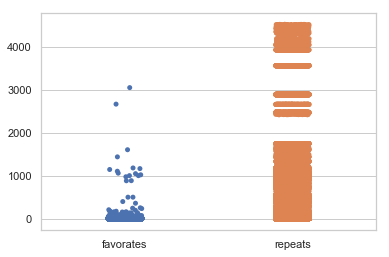

In [89]:
sns.stripplot(data=df_stream[['favorates', 'repeats']])

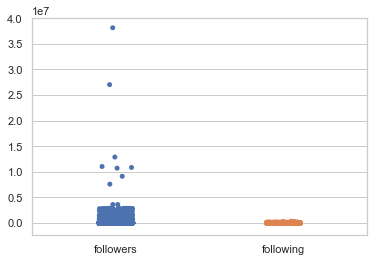

In [90]:
sns.stripplot(data=df_stream[['followers', 'following']])

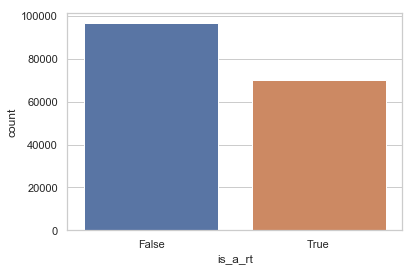

In [91]:
sns.countplot(df_stream['is_a_rt'])

In [92]:
len(df_stream['id'].unique())

166631

In [93]:
len(df_stream['date'].unique())

69

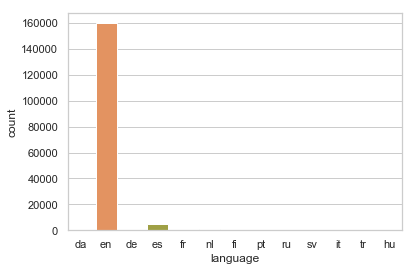

In [94]:
sns.countplot(df_stream['language'])

In [95]:
df_stream.head()

,id,date,hour,username,nickname,bio,content,favorates,repeats,latitude,longitude,country,place,followers,following,listed,language,tweet_url,is_a_rt,origianl_username,mentions,hashtags,symbols,media,urls
0,743056393796739072,2016-06-15,12:23,Sufiy,Sufiy,#Investing as a way of life based on common se...,RT @kirillklip: Race for #renewable #energy #t...,0.0,4.0,NaN,NaN,NaN,NaN,1798.0,2111.0,537.0,da,http://www.twitter.com/Sufiy/status/7430563937...,True,@kirillklip,@kirillklip,"#renewable,#energy,#technologies,#lithium,#hed...","$LIT,$ILV.v,$TSLA,$AAPL",NaN,http://www.bnn.ca/News/2016/5/7/Race-for-renew...
1,743055905214889984,2016-06-15,12:21,Breaking News,HotpageNews,One Stop Shop for BREAKING AND TRENDING NEWS. ...,#APPLE TRIES to Limit #Google Incursions Onto ...,0.0,0.0,42.35843,-71.05977,US,Boston,222.0,346.0,163.0,en,http://www.twitter.com/HotpageNews/status/7430...,False,NaN,NaN,"#APPLE,#Google","$AAPL,$GOOG",NaN,http://hotpagenews.com/r/150730
2,743055905193857024,2016-06-15,12:21,Hotpage News,Hotpage_News,The One Stop WEBSITE for Breaking and Trending...,#APPLE TRIES to Limit #Google Incursions Onto ...,0.0,0.0,NaN,NaN,NaN,NaN,16177.0,1333.0,427.0,en,http://www.twitter.com/Hotpage_News/status/743...,False,NaN,NaN,"#APPLE,#Google","$AAPL,$GOOG",NaN,http://hotpagenews.com/r/150730
3,743055497725673472,2016-06-15,12:20,Danny,TraderDanny77,"Family Man, entrepreneur, wanna be trader, Tha...",What calls do I sell on $twtr\n\n$spy $aapl $g...,0.0,0.0,46.47747,30.73262,UA,"Odessa, FL",87.0,406.0,5.0,en,http://www.twitter.com/TraderDanny77/status/74...,False,NaN,NaN,NaN,"$twtr,$spy,$aapl,$googl,$tsla,$ibm,$wba,$scty,...",NaN,NaN
4,743055311909441536,2016-06-15,12:19,Jayson,hovastocks,Father | Investor in life | Runner | Cyclist,Good for $AAPL pay? https://t.co/6EuitFi8Au,0.0,0.0,NaN,NaN,NaN,NaN,387.0,353.0,20.0,en,http://www.twitter.com/hovastocks/status/74305...,False,NaN,NaN,NaN,$AAPL,NaN,https://twitter.com/businessinsider/status/742...


In [96]:
# Drop the useless columns
drop_list = ['nickname', 'bio', 'latitude', 'longitude', 'place', 'listed', 'tweet_url', 'origianl_username', 'media', 'urls']
df = df_stream.drop(drop_list, axis=1)

In [97]:
df

,id,date,hour,username,content,favorates,repeats,country,followers,following,language,is_a_rt,mentions,hashtags,symbols
0,743056393796739072,2016-06-15,12:23,Sufiy,RT @kirillklip: Race for #renewable #energy #t...,0.0,4.0,NaN,1798.0,2111.0,da,True,@kirillklip,"#renewable,#energy,#technologies,#lithium,#hed...","$LIT,$ILV.v,$TSLA,$AAPL"
1,743055905214889984,2016-06-15,12:21,Breaking News,#APPLE TRIES to Limit #Google Incursions Onto ...,0.0,0.0,US,222.0,346.0,en,False,NaN,"#APPLE,#Google","$AAPL,$GOOG"
2,743055905193857024,2016-06-15,12:21,Hotpage News,#APPLE TRIES to Limit #Google Incursions Onto ...,0.0,0.0,NaN,16177.0,1333.0,en,False,NaN,"#APPLE,#Google","$AAPL,$GOOG"
3,743055497725673472,2016-06-15,12:20,Danny,What calls do I sell on $twtr\n\n$spy $aapl $g...,0.0,0.0,UA,87.0,406.0,en,False,NaN,NaN,"$twtr,$spy,$aapl,$googl,$tsla,$ibm,$wba,$scty,..."
4,743055311909441536,2016-06-15,12:19,Jayson,Good for $AAPL pay? https://t.co/6EuitFi8Au,0.0,0.0,NaN,387.0,353.0,en,False,NaN,NaN,$AAPL
5,743055468315185152,2016-06-15,12:20,Jennifer Booton,Apple may again see a super cycle akin to the ...,1.0,0.0,GB,6795.0,1397.0,en,False,NaN,NaN,$AAPL
6,743055167143194624,2016-06-15,12:18,ciara linnane,Time to talk iPhone 8: Apple ‘super cycle’ exp...,0.0,1.0,GB,1848.0,336.0,en,False,NaN,NaN,$AAPL
7,743054736878936068,2016-06-15,12:17,Pete Rickels,Where will $AAPL pin on Friday's OPEX?,0.0,0.0,NaN,2.0,10.0,en,False,NaN,NaN,$AAPL
8,743053821732114433,2016-06-15,12:13,Danny,@jack $lnkd $twtr $spy $aapl $tsla $fb $ibm $s...,0.0,0.0,UA,87.0,406.0,en,False,@jack,NaN,"$lnkd,$twtr,$spy,$aapl,$tsla,$fb,$ibm,$sq"
9,743053820364783617,2016-06-15,12:13,Andreas Andersen,RT @andreascseh: #iPhone6s vs #iPhone7: 4 Reas...,0.0,1.0,HU,396.0,636.0,en,True,"@andreascseh,@NorbiJr,@simonting,@tipsclear,@D...","#iPhone6s,#iPhone7,#Apple",$AAPL


In [98]:
# Convert to datetime type
df['date'] = pd.to_datetime(df['date'])

In [99]:
# Filter the observation
df = df[df['language'] == 'en']

In [100]:
# df = df.drop('language', axis=1)
df = df.drop('language', axis=1)

In [101]:
df['country'].value_counts().head(10)

US    30312
GB    15382
CA     2126
IN      829
JE      550
IE      550
AU      429
FR      406
ES      393
DE      385
Name: country, dtype: int64

In [102]:
print(df['date'].min())
print(df['date'].max())

2016-04-02 00:00:00
2016-06-15 00:00:00


# DATA CLEANING

In [103]:
# Date cleaning for tweet content
warnings.simplefilter('ignore')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/Chile/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [104]:
## Removing stop words, punctuation and tokenizing
stop = stopwords.words('english')
stop = stop + ['rt','amp']

In [105]:
def clean_tweet_split(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        p = ' '.join(re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)", " ", tweet).split())
        s = ' '.join(re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9_]+)", " ", p).split())
        return ' '.join(re.sub("(\w+:\/\/\S+)", " ", s).split())
    

# function for lemmatization

lemma = nltk.wordnet.WordNetLemmatizer()
def lemmatize(text):
    return lemma.lemmatize(text)



def bigrams(words, bi_min=15, tri_min=10):
    """
    Get Bigrams
    """
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod


def get_corpus(df):
    """
    Get Bigram Model, Corpus, id2word mapping
    """
    bigram = bigrams(df.tweet_tokens_lem)
    bigram = [bigram[tweet] for tweet in df.tweet_tokens_lem]
    id2word = gensim.corpora.Dictionary(bigram)
    id2word.filter_extremes(no_below=10, no_above=0.35)
    id2word.compactify()
    corpus = [id2word.doc2bow(text) for text in bigram]
    return corpus, id2word, bigram


def remove_links(tweet):
        '''
        Utility function to clean tweet text by removing links, special characters
        using simple regex statements.
        '''
        return ' '.join(re.sub("(\w+:\/\/\S+)", " ", tweet).split())

In [106]:
# Performed Lemmitization and Tokenization
df['tweet_clean'] = df['content'].apply(lambda tweet: clean_tweet_split(tweet))
df['tweet_tokens'] = df['tweet_clean'].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
df['tweet_tokens'] = df['tweet_tokens'].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])
df['tweet_tokens_lem'] = df['tweet_tokens'].apply(lambda list_of_words: [lemmatize(x) for x in list_of_words])

In [107]:
# Removing Less Frequent words
df['tweet_new'] = df['content'].apply(lambda tweet: remove_links(tweet))
df['tweet_new'] = df['tweet_new'].apply(lambda each_post: word_tokenize(re.sub(r'[^\w\s]',' ',each_post.lower())))
df['tweet_new'] = df['tweet_new'].apply(lambda list_of_words: [x for x in list_of_words if x not in stop])

In [108]:
group = df.groupby('username')

In [109]:
tweet_count = group['id'].count()

In [110]:
tweet_count.sort_values(ascending=False).head(15)

username
Peripheral News         6971
Computer News           6920
Electronic News         6372
trader whodont trade    4703
Tim Spencer             1636
Sam Miller              1619
MacHash                 1447
The Stock Professor     1233
John Lee                1162
David Moadel            1029
Stakepool                983
NASDAQStocks             977
AAPL Stock Alerts        892
Stock News Herald        845
Capital Market Labs      645
Name: id, dtype: int64

In [111]:
users = ['Peripheral News',
         'Computer News',
         'Electronic News',
         'trader whodont trade',
         'Tim Spencer',
         'Sam Miller',
         'MacHash',
         'The Stock Professor',
         'John Lee',
         'David Moadel',
         'Stakepool',
         'NASDAQStocks',
         'AAPL Stock Alerts',
         'Stock News Herald',
         'Capital Market Labs']

In [115]:
df = df.loc[df['username'].isin(users),:]

In [116]:
df.to_csv('kol.csv')

In [117]:
df

,id,date,hour,username,content,favorates,repeats,country,followers,following,is_a_rt,mentions,hashtags,symbols,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new
18,743051729990615040,2016-06-15,12:05,MacHash,Supply-chain report suggests Apple Watch 2 lau...,0.0,1.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Supply-chain report suggests Apple Watch 2 lau...,"[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch..."
20,743050445774409728,2016-06-15,12:00,AAPL Stock Alerts,Apple And Amazon: A Portfolio Only Needs One h...,0.0,0.0,GB,1875.0,15.0,False,NaN,NaN,"$AAPL,$AMZN",Apple And Amazon: A Portfolio Only Needs One $...,"[apple, amazon, portfolio, needs, one, aapl, a...","[apple, amazon, portfolio, need, one, aapl, amzn]","[apple, amazon, portfolio, needs, one, aapl, a..."
44,743043919613566976,2016-06-15,11:34,MacHash,Apple's Trent Reznor Bashes Google for buildin...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#PatentlyApple,$AAPL,Apple's Trent Reznor Bashes Google for buildin...,"[apple, trent, reznor, bashes, google, buildin...","[apple, trent, reznor, bash, google, building,...","[apple, trent, reznor, bashes, google, buildin..."
66,743036254887936001,2016-06-15,11:03,Capital Market Labs,RT @YahooFinance: Apple tries to limit Google ...,0.0,11.0,NaN,2140.0,40.0,True,@YahooFinance,NaN,"$AAPL,$GOOGL",RT : Apple tries to limit Google incursions on...,"[apple, tries, limit, google, incursions, onto...","[apple, try, limit, google, incursion, onto, d...","[yahoofinance, apple, tries, limit, google, in..."
67,743036133462802432,2016-06-15,11:03,MacHash,Purported iPhone 7 photos claims to show new t...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Purported iPhone 7 photos claims to show new t...,"[purported, iphone, 7, photos, claims, show, n...","[purported, iphone, 7, photo, claim, show, new...","[purported, iphone, 7, photos, claims, show, n..."
84,743029030224572416,2016-06-15,10:35,Stakepool,RT @NASDboy: $AAPL nice already up n ripping,0.0,2.0,GB,28484.0,6.0,True,@NASDboy,NaN,$AAPL,RT : $AAPL nice already up n ripping,"[aapl, nice, already, n, ripping]","[aapl, nice, already, n, ripping]","[nasdboy, aapl, nice, already, n, ripping]"
85,743029028844646400,2016-06-15,10:34,Stakepool,RT @ProTradersNews: $AAPL $ULTA:\n\nBirchbox R...,0.0,2.0,GB,28403.0,6.0,True,@ProTradersNews,NaN,"$AAPL,$ULTA",RT : $AAPL $ULTA: Birchbox Retrenches Amid Rap...,"[aapl, ulta, birchbox, retrenches, amid, rapid...","[aapl, ulta, birchbox, retrenches, amid, rapid...","[protradersnews, aapl, ulta, birchbox, retrenc..."
86,743029027640868864,2016-06-15,10:34,Stakepool,"RT @BoardCentral: $AAPL ""Re: added a few puts ...",0.0,2.0,GB,28484.0,6.0,True,@BoardCentral,NaN,$AAPL,"RT : $AAPL ""Re: added a few puts around 97.40,...","[aapl, added, puts, around, 97, 40, trying, ex...","[aapl, added, put, around, 97, 40, trying, ext...","[boardcentral, aapl, added, puts, around, 97, ..."
87,743029011559944196,2016-06-15,10:34,Stakepool,RT @tradewithmojo: $XIV $AAPL $SPX $SPY $ES_F ...,0.0,3.0,GB,28484.0,6.0,True,@tradewithmojo,NaN,"$XIV,$AAPL,$SPX,$SPY,$ES_F",RT : $XIV $AAPL $SPX $SPY $ES_F 2077+ very BUL...,"[xiv, aapl, spx, spy, es_f, 2077, bullish, away]","[xiv, aapl, spx, spy, es_f, 2077, bullish, away]","[tradewithmojo, xiv, aapl, spx, spy, es_f, 207..."
89,743028246212714496,2016-06-15,10:31,trader whodont trade,RT @NASDboy: $AAPL nice already up n ripping,0.0,2.0,NaN,1199.0,1135.0,True,@NASDboy,NaN,$AAPL,RT : $AAPL nice already up n ripping,"[aapl, nice, already, n, ripping]","[aapl, nice, already, n, ripping]","[nasdboy, aapl, nice, already, n, ripping]"


# Sentiment analysis

In [118]:
import pandas as pd
import numpy as np
import re 
from textblob import TextBlob 
from sklearn import linear_model
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

In [119]:
# Number of tweets for each KOL
df.groupby(['username'])['content'].count()

username
AAPL Stock Alerts        892
Capital Market Labs      645
Computer News           6920
David Moadel            1029
Electronic News         6372
John Lee                1162
MacHash                 1447
NASDAQStocks             977
Peripheral News         6971
Sam Miller              1619
Stakepool                983
Stock News Herald        845
The Stock Professor     1233
Tim Spencer             1636
trader whodont trade    4703
Name: content, dtype: int64

In [120]:
df.head()

,id,date,hour,username,content,favorates,repeats,country,followers,following,is_a_rt,mentions,hashtags,symbols,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new
18,743051729990615040,2016-06-15,12:05,MacHash,Supply-chain report suggests Apple Watch 2 lau...,0.0,1.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Supply-chain report suggests Apple Watch 2 lau...,"[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch..."
20,743050445774409728,2016-06-15,12:00,AAPL Stock Alerts,Apple And Amazon: A Portfolio Only Needs One h...,0.0,0.0,GB,1875.0,15.0,False,NaN,NaN,"$AAPL,$AMZN",Apple And Amazon: A Portfolio Only Needs One $...,"[apple, amazon, portfolio, needs, one, aapl, a...","[apple, amazon, portfolio, need, one, aapl, amzn]","[apple, amazon, portfolio, needs, one, aapl, a..."
44,743043919613566976,2016-06-15,11:34,MacHash,Apple's Trent Reznor Bashes Google for buildin...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#PatentlyApple,$AAPL,Apple's Trent Reznor Bashes Google for buildin...,"[apple, trent, reznor, bashes, google, buildin...","[apple, trent, reznor, bash, google, building,...","[apple, trent, reznor, bashes, google, buildin..."
66,743036254887936001,2016-06-15,11:03,Capital Market Labs,RT @YahooFinance: Apple tries to limit Google ...,0.0,11.0,NaN,2140.0,40.0,True,@YahooFinance,NaN,"$AAPL,$GOOGL",RT : Apple tries to limit Google incursions on...,"[apple, tries, limit, google, incursions, onto...","[apple, try, limit, google, incursion, onto, d...","[yahoofinance, apple, tries, limit, google, in..."
67,743036133462802432,2016-06-15,11:03,MacHash,Purported iPhone 7 photos claims to show new t...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Purported iPhone 7 photos claims to show new t...,"[purported, iphone, 7, photos, claims, show, n...","[purported, iphone, 7, photo, claim, show, new...","[purported, iphone, 7, photos, claims, show, n..."


In [121]:
# Sentiment Analysis functions:

def get_tweet_sentiment(tweet): 
        ''' 
        Utility function to classify sentiment of passed tweet 
        using textblob's sentiment method 
        '''
        # create TextBlob object of passed tweet text 
        analysis = TextBlob(tweet) 
        return analysis.sentiment.polarity
        
def sentiment_buckets(score):
        ''' 
        Utility function to classify the sentiment bucket 
        '''
        # set sentiment : 5% offset
        if score > 0.05: 
            return 'positive'
        elif score < -0.05: 
            return 'negative'
        else: 
            return 'neutral'

In [122]:
# create sentiment score and sentiment bucket columns
df['sentiment_score']=df['tweet_clean'].map(get_tweet_sentiment)
df['sentiment_bucket']=df['sentiment_score'].map(sentiment_buckets)
df[:5]

,id,date,hour,username,content,favorates,repeats,country,followers,following,is_a_rt,mentions,hashtags,symbols,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,sentiment_score,sentiment_bucket
18,743051729990615040,2016-06-15,12:05,MacHash,Supply-chain report suggests Apple Watch 2 lau...,0.0,1.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Supply-chain report suggests Apple Watch 2 lau...,"[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...",0.000000,neutral
20,743050445774409728,2016-06-15,12:00,AAPL Stock Alerts,Apple And Amazon: A Portfolio Only Needs One h...,0.0,0.0,GB,1875.0,15.0,False,NaN,NaN,"$AAPL,$AMZN",Apple And Amazon: A Portfolio Only Needs One $...,"[apple, amazon, portfolio, needs, one, aapl, a...","[apple, amazon, portfolio, need, one, aapl, amzn]","[apple, amazon, portfolio, needs, one, aapl, a...",0.000000,neutral
44,743043919613566976,2016-06-15,11:34,MacHash,Apple's Trent Reznor Bashes Google for buildin...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#PatentlyApple,$AAPL,Apple's Trent Reznor Bashes Google for buildin...,"[apple, trent, reznor, bashes, google, buildin...","[apple, trent, reznor, bash, google, building,...","[apple, trent, reznor, bashes, google, buildin...",0.000000,neutral
66,743036254887936001,2016-06-15,11:03,Capital Market Labs,RT @YahooFinance: Apple tries to limit Google ...,0.0,11.0,NaN,2140.0,40.0,True,@YahooFinance,NaN,"$AAPL,$GOOGL",RT : Apple tries to limit Google incursions on...,"[apple, tries, limit, google, incursions, onto...","[apple, try, limit, google, incursion, onto, d...","[yahoofinance, apple, tries, limit, google, in...",-0.100000,negative
67,743036133462802432,2016-06-15,11:03,MacHash,Purported iPhone 7 photos claims to show new t...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Purported iPhone 7 photos claims to show new t...,"[purported, iphone, 7, photos, claims, show, n...","[purported, iphone, 7, photo, claim, show, new...","[purported, iphone, 7, photos, claims, show, n...",0.136364,positive


# Sentiment EDA

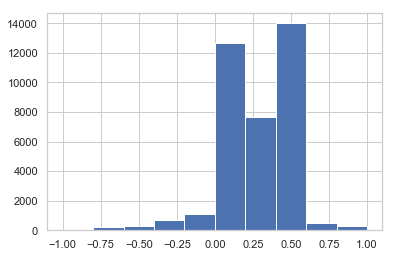

In [123]:
# sentiment EDA :
# Sentiment score distrution
df['sentiment_score'].hist()

In [124]:
# KOL level sentiment EDA:
# sentiment score statistics 
df.groupby('username')['sentiment_score'].agg(['min','max','mean','median'])

,min,max,mean,median
username,,,,
AAPL Stock Alerts,-0.700000,1.000000,0.055810,0.000000
Capital Market Labs,-1.000000,1.000000,0.026559,0.000000
Computer News,-0.366667,0.750000,0.384417,0.500000
David Moadel,-1.000000,1.000000,0.056065,0.000000
Electronic News,-0.366667,0.833333,0.384793,0.500000
John Lee,-1.000000,1.000000,0.045557,0.000000
MacHash,-1.000000,1.000000,0.089043,0.000000
NASDAQStocks,-1.000000,1.000000,0.132996,0.000000
Peripheral News,-0.366667,0.750000,0.383839,0.500000


In [126]:
# sentiment score table to calculate % distrbution for sentiment buckets
df_sent_bucket=pd.DataFrame(df.groupby(['username','sentiment_bucket'])['sentiment_score'].agg('count'))
df_sent_bucket=df_sent_bucket.reset_index()
df_sent_bucket.columns=['username','sentiment_bucket','tweet_cnt']
df_sent_bucket[:5]

,username,sentiment_bucket,tweet_cnt
0,AAPL Stock Alerts,negative,124
1,AAPL Stock Alerts,neutral,519
2,AAPL Stock Alerts,positive,249
3,Capital Market Labs,negative,106
4,Capital Market Labs,neutral,345


In [127]:
#pivot the results
df_sent_pivot= pd.pivot_table(df_sent_bucket,index=['username'],columns=['sentiment_bucket']).fillna(0)
df_sent_pivot['perc_negative']=df_sent_pivot['tweet_cnt']['negative']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot['perc_positive']=df_sent_pivot['tweet_cnt']['positive']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot['perc_neutral']=df_sent_pivot['tweet_cnt']['neutral']*100/(df_sent_pivot['tweet_cnt']['negative']+df_sent_pivot['tweet_cnt']['positive']+df_sent_pivot['tweet_cnt']['neutral'])
df_sent_pivot

tweet_cnt                  perc_negative perc_positive  \
sentiment_bucket      negative neutral positive                               
username                                                                      
AAPL Stock Alerts          124     519      249     13.901345     27.914798   
Capital Market Labs        106     345      194     16.434109     30.077519   
Computer News               56     199     6665      0.809249     96.315029   
David Moadel               175     532      322     17.006803     31.292517   
Electronic News             56     171     6145      0.878845     96.437539   
John Lee                   123     790      249     10.585198     21.428571   
MacHash                    158     770      519     10.919143     35.867312   
NASDAQStocks                82     530      365      8.393040     37.359263   
Peripheral News             60     202     6709      0.860709     96.241572   
Sam Miller                 167     917      535     10.315009     33.045090   
Stakepool                   72     502      409      7.324517     41.607325   
Stock News Herald            2       4      839      0.236686     99.289941   
The Stock Professor        234     657      342     18.978102     27.737226   
Tim Spencer                190     820      626     11.613692     38.264059   
trader whodont trade       451    2157     2095      9.589624     44.546034   

                     perc_neutral  
sentiment_bucket                   
username                           
AAPL Stock Alerts       58.183857  
Capital Market Labs     53.488372  
Computer News            2.875723  
David Moadel            51.700680  
Electronic News          2.683616  
John Lee                67.986231  
MacHash                 53.213545  
NASDAQStocks            54.247697  
Peripheral News          2.897719  
Sam Miller              56.639901  
Stakepool               51.068159  
Stock News Herald        0.473373  
The Stock Professor     53.284672  
Tim Spencer             50.122249  
trader whodont trade    45.864342

## Bag of words analysis

In [128]:
# import the necessary libraries

import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
from nltk import pos_tag, word_tokenize
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances

In [129]:
#Obtain POS for the tokens
#import nltk
nltk.download('averaged_perceptron_tagger')
df['pos']=df['tweet_tokens'].apply(nltk.tag.pos_tag)
df[:5]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Chile/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,id,date,hour,username,content,favorates,repeats,country,followers,following,is_a_rt,mentions,hashtags,symbols,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,sentiment_score,sentiment_bucket,pos
18,743051729990615040,2016-06-15,12:05,MacHash,Supply-chain report suggests Apple Watch 2 lau...,0.0,1.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Supply-chain report suggests Apple Watch 2 lau...,"[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...",0.000000,neutral,"[(supply, NN), (chain, NN), (report, NN), (sug..."
20,743050445774409728,2016-06-15,12:00,AAPL Stock Alerts,Apple And Amazon: A Portfolio Only Needs One h...,0.0,0.0,GB,1875.0,15.0,False,NaN,NaN,"$AAPL,$AMZN",Apple And Amazon: A Portfolio Only Needs One $...,"[apple, amazon, portfolio, needs, one, aapl, a...","[apple, amazon, portfolio, need, one, aapl, amzn]","[apple, amazon, portfolio, needs, one, aapl, a...",0.000000,neutral,"[(apple, NN), (amazon, NN), (portfolio, NN), (..."
44,743043919613566976,2016-06-15,11:34,MacHash,Apple's Trent Reznor Bashes Google for buildin...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#PatentlyApple,$AAPL,Apple's Trent Reznor Bashes Google for buildin...,"[apple, trent, reznor, bashes, google, buildin...","[apple, trent, reznor, bash, google, building,...","[apple, trent, reznor, bashes, google, buildin...",0.000000,neutral,"[(apple, NN), (trent, NN), (reznor, NN), (bash..."
66,743036254887936001,2016-06-15,11:03,Capital Market Labs,RT @YahooFinance: Apple tries to limit Google ...,0.0,11.0,NaN,2140.0,40.0,True,@YahooFinance,NaN,"$AAPL,$GOOGL",RT : Apple tries to limit Google incursions on...,"[apple, tries, limit, google, incursions, onto...","[apple, try, limit, google, incursion, onto, d...","[yahoofinance, apple, tries, limit, google, in...",-0.100000,negative,"[(apple, NN), (tries, NNS), (limit, VBP), (goo..."
67,743036133462802432,2016-06-15,11:03,MacHash,Purported iPhone 7 photos claims to show new t...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Purported iPhone 7 photos claims to show new t...,"[purported, iphone, 7, photos, claims, show, n...","[purported, iphone, 7, photo, claim, show, new...","[purported, iphone, 7, photos, claims, show, n...",0.136364,positive,"[(purported, VBN), (iphone, NN), (7, CD), (pho..."


In [130]:
df.sentiment_bucket.value_counts()

positive    26263
neutral      9115
negative     2056
Name: sentiment_bucket, dtype: int64

In [131]:
# Extract the list of nouns to create manual buckets based on them:
df['nouns']=df['pos'].apply(lambda pos_list: [x[0] for x in pos_list if x[1].startswith('NN')])
df[:5]

,id,date,hour,username,content,favorates,repeats,country,followers,following,is_a_rt,mentions,hashtags,symbols,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,sentiment_score,sentiment_bucket,pos,nouns
18,743051729990615040,2016-06-15,12:05,MacHash,Supply-chain report suggests Apple Watch 2 lau...,0.0,1.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Supply-chain report suggests Apple Watch 2 lau...,"[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...",0.000000,neutral,"[(supply, NN), (chain, NN), (report, NN), (sug...","[supply, chain, report, apple, watch, launch, ..."
20,743050445774409728,2016-06-15,12:00,AAPL Stock Alerts,Apple And Amazon: A Portfolio Only Needs One h...,0.0,0.0,GB,1875.0,15.0,False,NaN,NaN,"$AAPL,$AMZN",Apple And Amazon: A Portfolio Only Needs One $...,"[apple, amazon, portfolio, needs, one, aapl, a...","[apple, amazon, portfolio, need, one, aapl, amzn]","[apple, amazon, portfolio, needs, one, aapl, a...",0.000000,neutral,"[(apple, NN), (amazon, NN), (portfolio, NN), (...","[apple, amazon, portfolio, aapl, amzn]"
44,743043919613566976,2016-06-15,11:34,MacHash,Apple's Trent Reznor Bashes Google for buildin...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#PatentlyApple,$AAPL,Apple's Trent Reznor Bashes Google for buildin...,"[apple, trent, reznor, bashes, google, buildin...","[apple, trent, reznor, bash, google, building,...","[apple, trent, reznor, bashes, google, buildin...",0.000000,neutral,"[(apple, NN), (trent, NN), (reznor, NN), (bash...","[apple, trent, reznor, bashes, building, music..."
66,743036254887936001,2016-06-15,11:03,Capital Market Labs,RT @YahooFinance: Apple tries to limit Google ...,0.0,11.0,NaN,2140.0,40.0,True,@YahooFinance,NaN,"$AAPL,$GOOGL",RT : Apple tries to limit Google incursions on...,"[apple, tries, limit, google, incursions, onto...","[apple, try, limit, google, incursion, onto, d...","[yahoofinance, apple, tries, limit, google, in...",-0.100000,negative,"[(apple, NN), (tries, NNS), (limit, VBP), (goo...","[apple, tries, incursions, devices, googl]"
67,743036133462802432,2016-06-15,11:03,MacHash,Purported iPhone 7 photos claims to show new t...,0.0,0.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Purported iPhone 7 photos claims to show new t...,"[purported, iphone, 7, photos, claims, show, n...","[purported, iphone, 7, photo, claim, show, new...","[purported, iphone, 7, photos, claims, show, n...",0.136364,positive,"[(purported, VBN), (iphone, NN), (7, CD), (pho...","[iphone, photos, claims, home, button, aapl]"


In [132]:
#Filter the noun list only to make the list of attributes 
noun_lst = df['nouns'].apply(pd.Series).stack().unique()

# # get the frequencies for the nouns:
noun_df= pd.DataFrame(noun_lst)
noun_df.columns=['nouns']
noun_df[:5]

,nouns
0,supply
1,chain
2,report
3,apple
4,watch


In [133]:
## get frequency of all words
all_words = df['nouns'].sum()
freq_dist = nltk.FreqDist(all_words)

df_fdist=pd.DataFrame(list(freq_dist.items()), columns=['term', 'freq'])

noun_freq_df = pd.merge(noun_df, df_fdist, right_on='term', left_on='nouns')


In [134]:
noun_freq_df.sort_values(by='freq', ascending=False).head(10)

,nouns,term,freq
6,aapl,aapl,32516
276,read,read,5449
3,apple,apple,5066
21,iphone,iphone,5035
50,fb,fb,3868
39,spy,spy,3194
132,goog,goog,2832
166,stock,stock,2079
263,tsla,tsla,2051
9,amzn,amzn,1779


In [135]:
# Export the file :
noun_freq_df.to_csv('nouns_tweets.csv')

In [136]:
df.head(2)

,id,date,hour,username,content,favorates,repeats,country,followers,following,is_a_rt,mentions,hashtags,symbols,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,sentiment_score,sentiment_bucket,pos,nouns
18,743051729990615040,2016-06-15,12:05,MacHash,Supply-chain report suggests Apple Watch 2 lau...,0.0,1.0,NaN,1520.0,281.0,False,NaN,#9to5Mac,$AAPL,Supply-chain report suggests Apple Watch 2 lau...,"[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...",0.0,neutral,"[(supply, NN), (chain, NN), (report, NN), (sug...","[supply, chain, report, apple, watch, launch, ..."
20,743050445774409728,2016-06-15,12:00,AAPL Stock Alerts,Apple And Amazon: A Portfolio Only Needs One h...,0.0,0.0,GB,1875.0,15.0,False,NaN,NaN,"$AAPL,$AMZN",Apple And Amazon: A Portfolio Only Needs One $...,"[apple, amazon, portfolio, needs, one, aapl, a...","[apple, amazon, portfolio, need, one, aapl, amzn]","[apple, amazon, portfolio, needs, one, aapl, a...",0.0,neutral,"[(apple, NN), (amazon, NN), (portfolio, NN), (...","[apple, amazon, portfolio, aapl, amzn]"


# LDA Analysis

In [137]:
def lda_analysis(df, num_topics):
    """
    function for LDA analysis
    """
#     df_lda = df[df['User Name']== username]
    
    all_words = df['tweet_new'].sum()
    freq_dist = nltk.FreqDist(all_words)
    df_fdist=pd.DataFrame(list(freq_dist.items()), columns=['term', 'freq'])
    
    df_fdist = df_fdist.sort_values(by = 'freq', ascending = False)
    df_fdist = df_fdist[df_fdist['freq'] > 1]
    
    relevant_words = list(df_fdist['term'])
    
    df["tweet_new"] = df["tweet_new"].apply(lambda list_of_words: [x for x in list_of_words if x in relevant_words])
    df["tweet_tokens_lem"] = df["tweet_new"].apply(lambda list_of_words: [lemmatize(x) for x in list_of_words])
    
    train_corpus, train_id2word, bigram_train = get_corpus(df)
    
    import logging
    logging.basicConfig(filename='lda_model.log', format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        lda_train = gensim.models.ldamulticore.LdaMulticore(
                               corpus=train_corpus,
                               num_topics=num_topics,
                               id2word=train_id2word,
                               chunksize=100,
                               workers=7, # Num. Processing Cores - 1
                               passes=50,
                               eval_every = 1,
                               per_word_topics=True,
                               random_state=11)
        lda_train.save('lda_train.model')
        
    coherence_model_lda = CoherenceModel(model=lda_train, texts=bigram_train, dictionary=train_id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print("The coherence of the LDA model is",coherence_lda)
    
    train_vecs = []
    for i in range(len(df.tweet_new)):
        top_topics = lda_train.get_document_topics(train_corpus[i], minimum_probability=0.0)
        topic_vec = [top_topics[i][1] for i in range(num_topics)]
        train_vecs.append(topic_vec)
    
    return df, lda_train.print_topics(), train_vecs, num_topics

def get_max_topics(values):
    topics = []
    if len(list(set(values))) == 1:
        topics = values     
    else:
        topics.append(max(values))
    
    return topics

def assign_topics(col1, col2):
    if col1 in col2:
        return 1
    else:
        return 0

## Topic modeling

In [138]:
df_lda, lda_results, train_vecs, num_topics = lda_analysis(df, 10)

The coherence of the LDA model is 0.34754494298864924


In [137]:
lda_results

[(0,
  '0.030*"car" + 0.024*"china" + 0.023*"tim_cook" + 0.022*"india" + 0.020*"service" + 0.019*"make" + 0.014*"end" + 0.012*"think" + 0.012*"right" + 0.011*"google"'),
 (1,
  '0.067*"iphone_7" + 0.036*"report" + 0.024*"say" + 0.016*"rumor" + 0.015*"show" + 0.014*"watch" + 0.013*"new" + 0.012*"phone" + 0.010*"supplier" + 0.009*"leak"'),
 (2,
  '0.069*"inc" + 0.037*"iphone_se" + 0.032*"stock" + 0.026*"buy" + 0.022*"launch" + 0.021*"invest" + 0.017*"facebook" + 0.017*"june" + 0.015*"analyst" + 0.015*"tesla"'),
 (3,
  '0.088*"stock_trading" + 0.078*"investing_fb" + 0.018*"tech" + 0.015*"app_store" + 0.015*"pay" + 0.013*"company" + 0.012*"new" + 0.012*"store" + 0.011*"user" + 0.010*"io"'),
 (4,
  '0.061*"spy" + 0.049*"goog" + 0.046*"tsla" + 0.040*"fb" + 0.029*"amzn" + 0.027*"new_weed" + 0.027*"cannabis_fb" + 0.027*"stock_ubqu" + 0.027*"marijuanastocks_weedstocks" + 0.027*"breakingnews_best"'),
 (5,
  '0.042*"new" + 0.030*"macbook" + 0.020*"feature" + 0.019*"siri" + 0.016*"fall" + 0.015*"a

In [140]:
train_vec_df=pd.DataFrame(train_vecs)
train_vec_df.columns=['Country',
                      'Product',
                      'Company',
                      'Stock_trading',
                      'Spy',
                      'Macbook',
                      'Iphone',
                      'Iwatch',
                      'Market',
                      'Tech'
                     ]

In [141]:
df = pd.concat([df_stream.reset_index(drop=True), train_vec_df.reset_index(drop=True)], axis=1)

In [142]:
df

,User Name,Tweet Id,Date,Tweet content,Repeats,Favorates,User Mentions,Hashtags,tweet_clean,tweet_tokens,tweet_tokens_lem,tweet_new,sentiment_score,sentiment_bucket,pos,nouns,Country,Product,Company,Stock_trading,Spy,Macbook,Iphone,Iwatch,Market,Tech
0,MacHash,743051729990615040,2016-06-15,Supply-chain report suggests Apple Watch 2 lau...,1.0,NaN,NaN,#9to5Mac,Supply-chain report suggests Apple Watch 2 lau...,"[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...","[supply, chain, report, suggests, apple, watch...",0.000000,neutral,"[(supply, NN), (chain, NN), (report, NN), (sug...","[supply, chain, report, apple, watch, launch, ...",0.011112,0.296902,0.378384,0.011112,0.011112,0.011113,0.011112,0.246926,0.011112,0.011117
1,AAPL Stock Alerts,743050445774409728,2016-06-15,Apple And Amazon: A Portfolio Only Needs One h...,NaN,NaN,NaN,NaN,Apple And Amazon: A Portfolio Only Needs One $...,"[apple, amazon, portfolio, needs, one, aapl, a...","[apple, amazon, portfolio, need, one, aapl, amzn]","[apple, amazon, portfolio, needs, one, aapl, a...",0.000000,neutral,"[(apple, NN), (amazon, NN), (portfolio, NN), (...","[apple, amazon, portfolio, aapl, amzn]",0.016667,0.016667,0.016668,0.016669,0.016671,0.016667,0.016669,0.254330,0.612322,0.016668
2,MacHash,743043919613566976,2016-06-15,Apple's Trent Reznor Bashes Google for buildin...,NaN,NaN,NaN,#PatentlyApple,Apple's Trent Reznor Bashes Google for buildin...,"[apple, trent, reznor, bashes, google, buildin...","[apple, google, building, music, video, platfo...","[apple, google, building, music, video, platfo...",0.000000,neutral,"[(apple, NN), (trent, NN), (reznor, NN), (bash...","[apple, trent, reznor, bashes, building, music...",0.012503,0.012502,0.012504,0.012502,0.012502,0.193463,0.012502,0.706520,0.012501,0.012501
3,Capital Market Labs,743036254887936001,2016-06-15,RT @YahooFinance: Apple tries to limit Google ...,11.0,NaN,@YahooFinance,NaN,RT : Apple tries to limit Google incursions on...,"[apple, tries, limit, google, incursions, onto...","[yahoofinance, apple, try, limit, google, onto...","[yahoofinance, apple, tries, limit, google, on...",-0.100000,negative,"[(apple, NN), (tries, NNS), (limit, VBP), (goo...","[apple, tries, incursions, devices, googl]",0.016674,0.016668,0.016668,0.016668,0.185272,0.016668,0.681371,0.016671,0.016668,0.016672
4,MacHash,743036133462802432,2016-06-15,Purported iPhone 7 photos claims to show new t...,NaN,NaN,NaN,#9to5Mac,Purported iPhone 7 photos claims to show new t...,"[purported, iphone, 7, photos, claims, show, n...","[purported, iphone, 7, photo, claim, show, new...","[purported, iphone, 7, photos, claims, show, n...",0.136364,positive,"[(purported, VBN), (iphone, NN), (7, CD), (pho...","[iphone, photos, claims, home, button, aapl]",0.010001,0.205600,0.010001,0.010001,0.010001,0.714394,0.010001,0.010001,0.010001,0.010001
5,Stakepool,743029030224572416,2016-06-15,RT @NASDboy: $AAPL nice already up n ripping,2.0,NaN,@NASDboy,NaN,RT : $AAPL nice already up n ripping,"[aapl, nice, already, n, ripping]","[nasdboy, aapl, nice, already, n, ripping]","[nasdboy, aapl, nice, already, n, ripping]",0.600000,positive,"[(aapl, JJ), (nice, JJ), (already, RB), (n, JJ...",[],0.020011,0.020004,0.020004,0.020004,0.020005,0.020004,0.819942,0.020008,0.020004,0.020013
6,Stakepool,743029028844646400,2016-06-15,RT @ProTradersNews: $AAPL $ULTA:\n\nBirchbox R...,2.0,NaN,@ProTradersNews,NaN,RT : $AAPL $ULTA: Birchbox Retrenches Amid Rap...,"[aapl, ulta, birchbox, retrenches, amid, rapid...","[protradersnews, aapl, ulta, birchbox, retrenc...","[protradersnews, aapl, ulta, birchbox, retrenc...",0.000000,neutral,"[(aapl, NN), (ulta, JJ), (birchbox, NN), (retr...","[aapl, birchbox, retrenches, rise, competition...",0.157008,0.014290,0.014290,0.014290,0.014290,0.014290,0.014290,0.728671,0.014290,0.014290
7,Stakepool,743029027640868864,2016-06-15,"RT @BoardCentral: $AAPL ""Re: added a few puts ...",2.0,NaN,@BoardCentral,NaN,"RT : $A

In [143]:
df['all_topics']= df[['Country',
                      'Product',
                      'Company',
                      'Stock_trading',
                      'Spy',
                      'Macbook',
                      'Iphone',
                      'Iwatch',
                      'Market',
                      'Tech']].values.tolist()
df['max_topics'] = df['all_topics'].apply(lambda values: get_max_topics(values))

In [144]:
df['Country'] = df.apply(lambda x: assign_topics(x['Country'], x['max_topics']), axis=1)
df['Product'] = df.apply(lambda x: assign_topics(x['Product'], x['max_topics']), axis=1)
df['Company'] = df.apply(lambda x: assign_topics(x['Company'], x['max_topics']), axis=1)
df['Stock_trading'] = df.apply(lambda x: assign_topics(x['Stock_trading'], x['max_topics']), axis=1)
df['Spy'] = df.apply(lambda x: assign_topics(x['Spy'], x['max_topics']), axis=1)
df['Macbook'] = df.apply(lambda x: assign_topics(x['Macbook'], x['max_topics']), axis=1)
df['Iphone'] = df.apply(lambda x: assign_topics(x['Iphone'], x['max_topics']), axis=1)
df['Iwatch'] = df.apply(lambda x: assign_topics(x['Iwatch'], x['max_topics']), axis=1)
df['Market'] = df.apply(lambda x: assign_topics(x['Market'], x['max_topics']), axis=1)
df['Tech'] = df.apply(lambda x: assign_topics(x['Tech'], x['max_topics']), axis=1)


In [146]:

average_topic_weights = df[['Country',
                      'Product',
                      'Company',
                      'Stock_trading',
                      'Spy',
                      'Macbook',
                      'Iphone',
                      'Iwatch',
                      'Market',
                      'Tech']].sum(axis=0)

In [147]:
average_topic_weights

Country          3075
Product          3678
Company          2639
Stock_trading    4113
Spy              4745
Macbook          2187
Iphone           4802
Iwatch           5208
Market           3620
Tech             3611
dtype: int64

In [148]:
topics = pd.DataFrame(average_topic_weights)

In [150]:
import chart_studio.plotly as py
py.plotly.tools.set_credentials_file(username='sah_lumos', api_key='9fCFTwIksEv3WNQFIZSL')

In [152]:
# plot pie chart for the major topics with their contribution in total number of tweets
import plotly.graph_objs as go
from palettable.colorbrewer.diverging import *

colors = Spectral_8.hex_colors

topics_pie = go.Pie(labels=topics.index, values=topics[0], marker=dict(colors=colors
                                                            , line=dict(color='#FFF', width=2)),
                                                            domain={'x': [0.0, .4], 'y': [0.0, 1]}
                                                            , showlegend=False, textinfo='label+percent')

layout = go.Layout(height = 600,
                   width = 1000,
                   autosize = False,
                   title = 'Topics Distribution of KOLs')
fig = go.Figure(data = topics_pie, layout = layout)

py.iplot(fig, filename='basic_pie_chart')

In [153]:
hashtags = df['Hashtags'].apply(pd.Series).stack()

hashtags_df= pd.DataFrame(hashtags)
hashtags_df.columns=['hashtags']

In [155]:
hashtags_df = pd.DataFrame(hashtags_df['hashtags'].value_counts()).reset_index()

In [157]:
hashtags_df['index'] = hashtags_df['index'].apply(lambda x:"Apple" if any(y in x.lower() for y in ["apple","airpod","iphone","ipad","macbook"]) else x)

In [158]:
hashtag_df = pd.DataFrame(hashtags_df["index"].value_counts()).reset_index()
hashtag_df.columns= ["hashtags","count"]

In [161]:
print(((hashtag_df[hashtag_df["hashtags"] == 'Apple']["count"]/hashtag_df["count"].sum())*100).values[0],"% of KOLs' hashtags are about apple products")

20.24825446082234 % of KOLs' hashtags are about apple products


In [163]:
# Distribution of tweets across manually created topics

df.groupby(['User Name'])[['Country',
                      'Product',
                      'Company',
                      'Stock_trading',
                      'Spy',
                      'Macbook',
                      'Iphone',
                      'Iwatch',
                      'Market',
                      'Tech']].sum()

,Country,Product,Company,Stock_trading,Spy,Macbook,Iphone,Iwatch,Market,Tech
User Name,,,,,,,,,,
AAPL Stock Alerts,87,46,95,58,135,33,193,98,115,59
Capital Market Labs,59,18,25,42,117,8,214,38,98,26
Computer News,666,1002,491,707,78,482,1129,1324,291,777
David Moadel,6,2,2,1,176,0,11,5,825,1
Electronic News,650,929,443,670,75,479,1000,1119,286,748
John Lee,14,3,12,1043,15,4,15,14,37,5
MacHash,62,197,69,158,6,108,115,517,25,190
NASDAQStocks,191,54,133,83,44,133,121,52,156,73
Peripheral News,689,1024,491,703,79,493,1105,1334,284,797


# ENGAGEMENT ANALYSIS

In [164]:
eng_df = df

In [169]:
eng_df

,User Name,Repeats,Favorates,User Mentions,sentiment_score,Country,Product,Company,Stock_trading,Spy,Macbook,Iphone,Iwatch,Market,Tech,max_topics
0,MacHash,1.0,NaN,NaN,0.000000,0,0,1,0,0,0,0,0,0,0,[0.37838417291641235]
1,AAPL Stock Alerts,NaN,NaN,NaN,0.000000,0,0,0,0,0,0,0,0,1,0,[0.6123217344284058]
2,MacHash,NaN,NaN,NaN,0.000000,0,0,0,0,0,0,0,1,0,0,[0.7065200805664062]
3,Capital Market Labs,11.0,NaN,@YahooFinance,-0.100000,0,0,0,0,0,0,1,0,0,0,[0.6813709735870361]
4,MacHash,NaN,NaN,NaN,0.136364,0,0,0,0,0,1,0,0,0,0,[0.7143940925598145]
5,Stakepool,2.0,NaN,@NASDboy,0.600000,0,0,0,0,0,0,1,0,0,0,[0.8199421167373657]
6,Stakepool,2.0,NaN,@ProTradersNews,0.000000,0,0,0,0,0,0,0,1,0,0,[0.7286707162857056]
7,Stakepool,2.0,NaN,@BoardCentral,-0.200000,0,0,0,0,0,0,0,0,1,0,[0.6952841877937317]
8,Stakepool,3.0,NaN,@tradewithmojo,0.312500,0,0,0,0,0,0,0,0,1,0,[0.4675789773464203]
9,trader whodont trade,2.0,NaN,@NASDboy,0.600000,0,0,0,0,0,0,1,0,0,0,[0.8199425935745239]


In [166]:
eng_df = eng_df.drop(['Tweet Id', 'Date', 'Tweet content', 'Hashtags', 'tweet_clean', 'tweet_tokens_lem', 'tweet_new', 'sentiment_bucket', 'pos', 'nouns'], axis=1)

In [168]:
eng_df = eng_df.drop(['all_topics', 'tweet_tokens'], axis=1)

In [177]:
eng_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37434 entries, 0 to 37433
Data columns (total 16 columns):
User Name          37434 non-null object
Repeats            37434 non-null float64
Favorates          1861 non-null float64
User Mentions      9714 non-null object
sentiment_score    37434 non-null float64
Country            37434 non-null int64
Product            37434 non-null int64
Company            37434 non-null int64
Stock_trading      37434 non-null int64
Spy                37434 non-null int64
Macbook            37434 non-null int64
Iphone             37434 non-null int64
Iwatch             37434 non-null int64
Market             37434 non-null int64
Tech               37434 non-null int64
max_topics         37434 non-null object
dtypes: float64(3), int64(10), object(3)
memory usage: 4.6+ MB


In [176]:
eng_df['Repeats'] = eng_df['Repeats'].fillna(0)

In [178]:
eng_df['Favorates'] = eng_df['Favorates'].fillna(0)

In [179]:
eng_df = eng_df.drop('User Mentions', axis=1)

In [181]:
eng_df = eng_df.drop('max_topics', axis=1)

In [185]:
eng_df['engagement_score']= 60 * eng_df['Repeats'] + 40 * eng_df['Favorates']
eng_df[:10]

,User Name,Repeats,Favorates,sentiment_score,Country,Product,Company,Stock_trading,Spy,Macbook,Iphone,Iwatch,Market,Tech,engagement_score
0,MacHash,1.0,0.0,0.000000,0,0,1,0,0,0,0,0,0,0,60.0
1,AAPL Stock Alerts,0.0,0.0,0.000000,0,0,0,0,0,0,0,0,1,0,0.0
2,MacHash,0.0,0.0,0.000000,0,0,0,0,0,0,0,1,0,0,0.0
3,Capital Market Labs,11.0,0.0,-0.100000,0,0,0,0,0,0,1,0,0,0,660.0
4,MacHash,0.0,0.0,0.136364,0,0,0,0,0,1,0,0,0,0,0.0
5,Stakepool,2.0,0.0,0.600000,0,0,0,0,0,0,1,0,0,0,120.0
6,Stakepool,2.0,0.0,0.000000,0,0,0,0,0,0,0,1,0,0,120.0
7,Stakepool,2.0,0.0,-0.200000,0,0,0,0,0,0,0,0,1,0,120.0
8,Stakepool,3.0,0.0,0.312500,0,0,0,0,0,0,0,0,1,0,180.0
9,trader whodont trade,2.0,0.0,0.600000,0,0,0,0,0,0,1,0,0,0,120.0


In [189]:
y = eng_df['engagement_score']
X = eng_df.drop(['engagement_score','User Name'], axis=1)

In [190]:
eng_model = sm.OLS(y, X).fit()
eng_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       engagement_score   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.603e+34
Date:                Wed, 03 Jun 2020   Prob (F-statistic):               0.00
Time:                        22:44:10   Log-Likelihood:             1.0492e+06
No. Observations:               37434   AIC:                        -2.098e+06
Df Residuals:                   37421   BIC:                        -2.098e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Repeats            60.0000   6.07e-17   9.88e+17      0.000      60.000      60.000
Favorates          40.0000   2.28e-15   1.75e+16      0.000      40.000      40.000
sentiment_score  -9.77e-15   3.24e-15     -3.013      0.003   -1.61e-14   -3.41e-15
Country           1.36e-14   3.06e-15      4.444      0.000     7.6e-15    1.96e-14
Product         -5.773e-15   2.86e-15     -2.022      0.043   -1.14e-14   -1.76e-16
Company          9.714e-14   3.26e-15     29.773      0.000    9.07e-14    1.04e-13
Stock_trading    2.764e-14   2.65e-15     10.420      0.000    2.24e-14    3.28e-14
Spy             -4.063e-14   2.45e-15    -16.601      0.000   -4.54e-14   -3.58e-14
Macbook         -2.537e-14   3.59e-15     -7.059      0.000   -3.24e-14   -1.83e-14
Iphone           6.883e-15   2.53e-15      2.723      0.006    1.93e-15    1.18e-14
Iwatch           8.882e-16   2.47e-15      0.359      0.719   -3.96e-15    5.73e-15
Market          -6.062e-14   2.78e-15    -21.795      0.000   -6.61e-14   -5.52e-14
Tech             2.598e-14   2.84e-15      9.162      0.000    2.04e-14    3.15e-14
==============================================================================
Omnibus:                   130206.770   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      47417742184.909
Skew:                         -66.860   Prob(JB):                         0.00
Kurtosis:                    5515.076   Cond. No.                         75.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

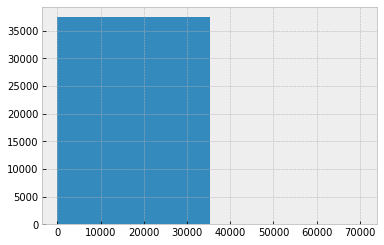

In [192]:
import matplotlib
#matplotlib.pyplot.scatter(engt_df['engagement_score'])

eng_df['engagement_score'].hist(bins=2)